<a href="https://colab.research.google.com/github/550tealeaves/DATA-70500-working-with-data/blob/main/ORIG_MachineLearningCensus2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning with Categorical Data: Multinomial Models

Building on the work we did in part I on maching learning models with categorical Census data, we'll look at a few techniques for models when the criterion variable (the dependent variable in the model, usually designated as Y) has more than two categories.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# We need to install these libraries to use some of the tools below.
!pip install pyreadstat
!pip install researchpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 24.6 MB/s eta 0:00:00


In [ ]:
# Code block 1: importing libraries
import pandas as pd
import numpy as np
import researchpy as rp
from pandas.api.types import CategoricalDtype
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio
import statsmodels.api as sm
import gzip


In [ ]:
# Because this Census data file is larger than ones we've used, we'll read the file
# as a compressed file using the gzip library.

census_df = pd.read_stata(gzip.open('/content/drive/MyDrive/Data/usa_00022.dta.gz', 'rb'))

In [ ]:
census_df.info('verbose')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3405809 entries, 0 to 3405808
Data columns (total 49 columns):
 #   Column      Dtype   
---  ------      -----   
 0   year        category
 1   sample      category
 2   serial      int32   
 3   cbserial    float64 
 4   hhwt        int16   
 5   cluster     float64 
 6   region      category
 7   statefip    category
 8   metro       category
 9   strata      int32   
 10  gq          category
 11  ownershp    category
 12  ownershpd   category
 13  mortgage    category
 14  mortamt1    category
 15  rentgrs     category
 16  hhincome    int32   
 17  rooms       category
 18  cinethh     category
 19  cihispeed   category
 20  coupletype  category
 21  ssmc        category
 22  nfams       category
 23  multgen     category
 24  multgend    category
 25  pernum      int8    
 26  perwt       int16   
 27  sex         category
 28  age         category
 29  marst       category
 30  hispan      category
 31  hispand     category
 32

In [ ]:
# We'll drop the cases where we don't know the employment status

census_df = census_df.loc[lambda census_df: census_df['empstat'] != 'n/a', :]

In [ ]:
census_df['empstat'].value_counts()

,count
empstat,
employed,1598838
not in labor force,1181150
unemployed,67657
n/a,0


Our criterion has three values: employed, not in labor force, and unemployed. The criterion is unbalanced, in that one category (unemployed) is much smaller than the others.

In [ ]:
# Here we're going to assign missing values to the category 'n/a' for all of our
# potential features (independent variables). This only works if the missing category
# is exactly 'n/a'. For other missing values, you have to do the modification separately.

category_list = ['region', 'ownershp', 'coupletype', 'multgen', 'sex', 'marst', 'hispan',
       'racamind', 'racasian', 'racblk', 'racpacis', 'racwht', 'educ']

for item in category_list:
    census_df[item] = np.where(census_df[item] == 'n/a', np.nan, census_df[item])


In [ ]:
census_df['south'] = np.where(census_df['region'].isin(['south atlantic division', 'west south central div', 'east south central div']), 1, 0)
census_df['south'].value_counts()

,count
south,
0,1759528
1,1088117


In [ ]:
census_df['multgen'].value_counts()

,count
multgen,
1 generation,1323383
2 generations,1163351
3+ generations,187316


In [ ]:
census_df['mult_gen_hh'] = np.where(census_df['multgen'] != '1 generation', 1, 0)
census_df['mult_gen_hh'].value_counts()

,count
mult_gen_hh,
1,1524262
0,1323383


In [ ]:
census_df['own_home'] = np.where(census_df['ownershp'] == 'owned or being bought (loan)', 1, 0)
census_df['own_home'].value_counts()

,count
own_home,
1,2034198
0,813447


In [ ]:
census_df['same_sex_cpl'] = np.where(census_df['coupletype'].isin(['same-sex husband/wife/spouse household', 'same-sex unmarried partner household']), 1, 0)
census_df['same_sex_cpl'].value_counts()

,count
same_sex_cpl,
0,2817123
1,30522


In [ ]:
census_df['female'] = np.where(census_df['sex'] == 'female', 1, 0)
census_df['female'].value_counts()

,count
female,
1,1462225
0,1385420


In [ ]:
census_df['rachisp'] = np.where(census_df['hispan'] != 'not hispanic', 1, 0)
census_df['rachisp'].value_counts()

,count
rachisp,
0,2434892
1,412753


In [ ]:
census_df['currently_married'] = np.where(census_df['marst'].isin(['married, spouse present', 'married, spouse absent']), 1, 0)
census_df['currently_married'].value_counts()

,count
currently_married,
1,1467696
0,1379949


In [ ]:
category_list = ['racamind', 'racasian', 'racblk', 'racpacis', 'racwht']

for item in category_list:
    census_df[item] = np.where(census_df[item] == 'yes', 1, 0)

census_df['racblk'].value_counts()

,count
racblk,
0,2562964
1,284681


In [ ]:
census_df['some_college'] = np.where(census_df['educ'].isin(['1 year of college', '2 years of college', '4 years of college', '5+ years of college']), 1, 0)
census_df['some_college'].value_counts()

,count
some_college,
1,1540404
0,1307241


Before we investigate the parameters of the machine learning models, let's briefly review how we might assess the quality of our categorization algorithm.

The diagnostics in the classification report tell us different things about the quality of the categorization. Accuracy is a proportion of the correct decisions  to the total number of decisions (number of cases). Precision refers to the ratio of true positives to the sum of true positives and false positives, or how many of the predicted positives are true. This is a good assessment when you want to minimize false positives.  Finally, recall, or sensitivity, is the ratio of true positives to the sum of true positives and false negatives. This is important when you don't want to miss any true positives--that is, to avoid false negatives. The f-score is a harmonic mean of precision and recall.

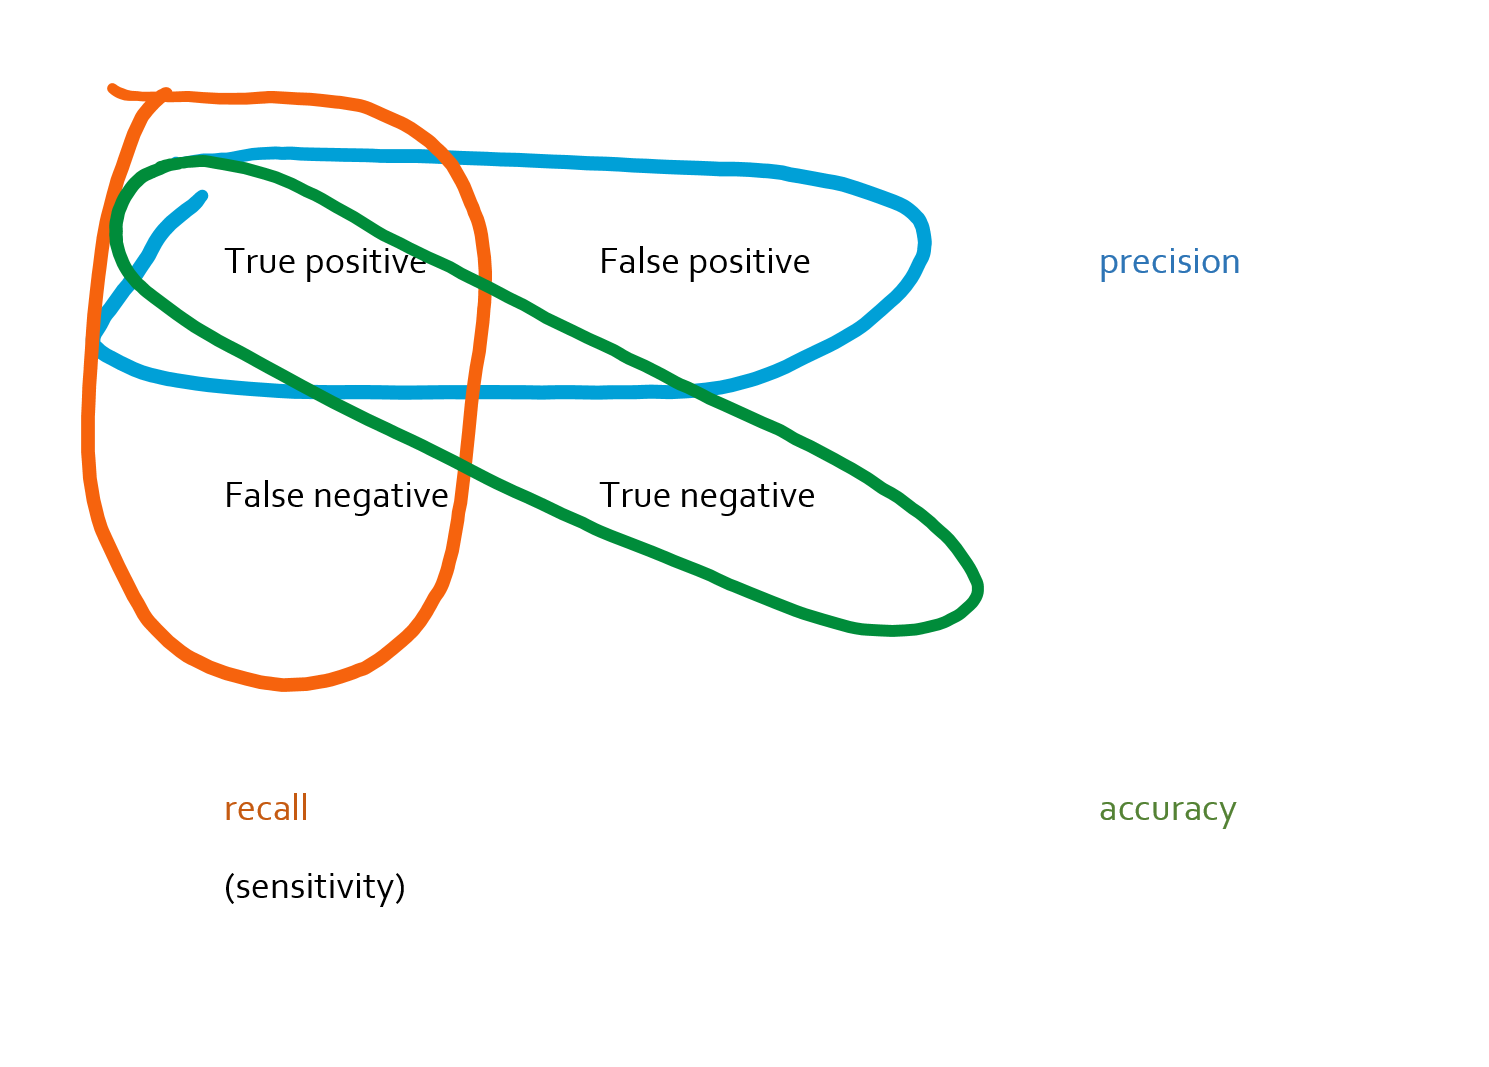

In [ ]:
#Use linear discriminant analysis
model_data_Y = census_df['empstat']
model_data_X = census_df[['south', 'own_home', 'same_sex_cpl', 'mult_gen_hh',
                          'female', 'rachisp', 'currently_married', 'some_college',
                          'racamind', 'racasian', 'racblk', 'racpacis', 'racwht']]

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    model_data_X, model_data_Y, test_size=0.33, random_state=0
)

model2 = lda(n_components=2).fit(X_train, y_train)
y_pred = model2.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, zero_division = 0))

#Accuracy is 60% - small # of unemployed in the test dataset
#Not correctly classifying any of the unemployed cases

                    precision    recall  f1-score   support

          employed       0.62      0.80      0.70    527866
not in labor force       0.56      0.37      0.45    389489
        unemployed       0.00      0.00      0.00     22368

          accuracy                           0.60    939723
         macro avg       0.39      0.39      0.38    939723
      weighted avg       0.58      0.60      0.58    939723



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    model_data_X, model_data_Y, test_size=0.33, random_state=0
)

from sklearn.svm import LinearSVC
model3 = LinearSVC(C = 1, max_iter = 10000000).fit(X_train, y_train)
y_pred = model3.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, zero_division = 0))

                    precision    recall  f1-score   support

          employed       0.62      0.80      0.70    527866
not in labor force       0.56      0.37      0.45    389489
        unemployed       0.00      0.00      0.00     22368

          accuracy                           0.60    939723
         macro avg       0.39      0.39      0.38    939723
      weighted avg       0.58      0.60      0.58    939723



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    model_data_X, model_data_Y, test_size=0.33, random_state=0
)

from sklearn.svm import SVC
model4 = SVC(C = 1, max_iter = 10000, gamma='scale').fit(X_train, y_train)
y_pred = model4.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, zero_division = 0))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    model_data_X, model_data_Y, test_size=0.33, random_state=0
)

from sklearn.naive_bayes import CategoricalNB
model5 = CategoricalNB().fit(X_train, y_train)
y_pred = model5.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, zero_division = 0))

                    precision    recall  f1-score   support

          employed       0.62      0.79      0.70    160365
not in labor force       0.56      0.39      0.46    117662
        unemployed       0.00      0.00      0.00      6738

          accuracy                           0.60    284765
         macro avg       0.39      0.39      0.38    284765
      weighted avg       0.58      0.60      0.58    284765



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    model_data_X, model_data_Y, test_size=0.33, random_state=0
)

from sklearn.linear_model import LogisticRegression
model6 = LogisticRegression(penalty='l2', random_state=0, C=0.01, max_iter=1000, solver='lbfgs').fit(X_train, y_train)
y_pred = model6.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, zero_division = 0))


                    precision    recall  f1-score   support

          employed       0.62      0.80      0.70    527866
not in labor force       0.56      0.37      0.45    389489
        unemployed       0.00      0.00      0.00     22368

          accuracy                           0.60    939723
         macro avg       0.39      0.39      0.38    939723
      weighted avg       0.58      0.60      0.58    939723



**None of the models is able to predict the unemployed category. The training data is dominated by the other two categories of the criterion, so the feature weights that get built into the model are not sensitive to the very small category.**

One solution to this problem is to split the original dataset into two samples. The first would include both employed and not in the labor force. The second would consist only of unemployed. We can then balance the training/test dataset by re-combining the two samples with various mixtures to evaluate the algorithm's ability to predict the small category.

In [ ]:
# We can adjust the mixture of our resampled data by changing the value of the frac=n flag.
# The smaller the value, the more balanced the re-sample will be, but it will also be smaller
# overall.
# We can start with 0.1 and work down until we get an acceptible mix.

# We want to take random sample of people from other 2 groups so that the groups are closer to being the same size (change mixture) iterative process

censusSample0_df = census_df.loc[lambda census_df: census_df['empstat'].isin(['employed', 'not in labor force']), :] #creates sample
censusSample0_df = censusSample0_df.sample(frac=0.05, axis=0, ignore_index=True) # frac=0.05 - 5% size of sample
print(len(censusSample0_df))

censusSample1_df = census_df.loc[lambda census_df: census_df['empstat'] == 'unemployed', :]
print(len(censusSample1_df))


138999
67657


In [ ]:
census2_df = pd.concat([censusSample0_df, censusSample1_df], axis=0, ignore_index=True)

Now, we'll re-run the analysis on census2_df.

In [ ]:
model_data_Y = census2_df['empstat']
model_data_X = census2_df[['south', 'own_home', 'same_sex_cpl', 'mult_gen_hh',
                          'female', 'rachisp', 'currently_married', 'some_college',
                          'racamind', 'racasian', 'racblk', 'racpacis', 'racwht']]

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    model_data_X, model_data_Y, test_size=0.33, random_state=0
)

model7 = lda(n_components=2).fit(X_train, y_train)
y_pred = model7.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, zero_division = 0))

#Not the best model (48% accurate) but can predict the unemployed with more accuracy than the previous models

                    precision    recall  f1-score   support

          employed       0.49      0.62      0.55     26326
not in labor force       0.45      0.26      0.33     19418
        unemployed       0.47      0.50      0.49     22453

          accuracy                           0.48     68197
         macro avg       0.47      0.46      0.46     68197
      weighted avg       0.47      0.48      0.47     68197



We're able to predict the unemployed category now, but poorly, and the overall accuracy of the algorithm has declined. **We can adjust the mixture of the re-sampling, and repeat as necessary. The more cases you retain, the more accurate the algorithm will be**